In [1]:
import pandas as pd
import pandas_ta as pa
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


**Sentiment Machine Learning:**

- Predicting whether to Long(1) OR Short(-1) using F&G strategy as a feature


- Target = perfect signal (1 if 'change' is positive, -1 if 'change' is negative)

**Strategy:**

- When F&G >= 95: position -1.0 (Short)

- When F&G >= 46: position 1.0 (Long)

- When F&G >= 22: position -1.0 (Short)

- When F&G < 22: position 1.0 (Long)

In [2]:
# CSV to dataframe
sentiment_df = pd.read_csv('../data_collection/2_positions_ETH.csv')
sentiment_df = sentiment_df.set_index('timestamp')
sentiment_df.index = pd.to_datetime(sentiment_df.index)

# Initialize perfect signal column
sentiment_df['perfect_signal'] = 0.0

# When 'change' is greater than or equal to 0, generate buy signal
sentiment_df.loc[(sentiment_df['change'] >= 0), 'perfect_signal'] = 1

# When 'change' is less than 0, generate short signal
sentiment_df.loc[(sentiment_df['change'] < 0), 'perfect_signal'] = -1

# get dummies on 'position' column
attributes = ['FG', 'Close', 'change', 'position', 'perfect_signal']
attributes_df = sentiment_df[attributes].copy()

attributes_df['position'] = pd.Categorical(attributes_df['position'])
dummies = pd.get_dummies(sentiment_df['position'], prefix='FG_signal')
attributes_df = attributes_df.drop(['position'], axis=1)
attributes_df = pd.concat([attributes_df, dummies], axis=1)
FGTA_df = attributes_df.copy()
attributes_df.head(5)

,FG,Close,change,perfect_signal,FG_signal_-1,FG_signal_1
timestamp,,,,,,
2018-02-02 00:00:00+00:00,15.0,915.784973,-0.116711,-1.0,0,1
2018-02-03 00:00:00+00:00,40.0,964.018982,0.052670,1.0,1,0
2018-02-04 00:00:00+00:00,24.0,834.682007,-0.134164,-1.0,1,0
2018-02-05 00:00:00+00:00,11.0,697.950989,-0.163812,-1.0,0,1
2018-02-06 00:00:00+00:00,8.0,793.122009,0.136358,1.0,0,1


**F&G as the only features:**

In [3]:
# Calculate the strategy returns and add to DataFrame
attributes_df['perfect_returns'] = attributes_df['change'] * attributes_df['perfect_signal']
# drop na
attributes_df['perfect_signal'] = attributes_df['perfect_signal'].dropna()
attributes_TA = attributes_df.copy()

In [4]:
# features
X = attributes_df[['FG', 'FG_signal_-1', 'FG_signal_1']].shift().dropna()

# target = perfect_signal (-1 = Short, 1 = Long)
y = attributes_df['perfect_signal'].dropna()
y.value_counts()

 1.0    927
-1.0    887
Name: perfect_signal, dtype: int64

In [5]:
# split training and testing
# start of the training period
training_begin = X.index.min()
# ending period for the training data with an offset of 40 months
training_end = X.index.min() + DateOffset(months=40)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:].dropna()
y_test = y.loc[training_end:].dropna()

X_test = X_test.iloc[1:]

# Scale features
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [6]:
# Create model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
svm_pred = svm_model.predict(X_train_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.44      0.48       587
         1.0       0.55      0.63      0.58       627

    accuracy                           0.54      1214
   macro avg       0.54      0.53      0.53      1214
weighted avg       0.54      0.54      0.53      1214



<AxesSubplot:xlabel='timestamp'>

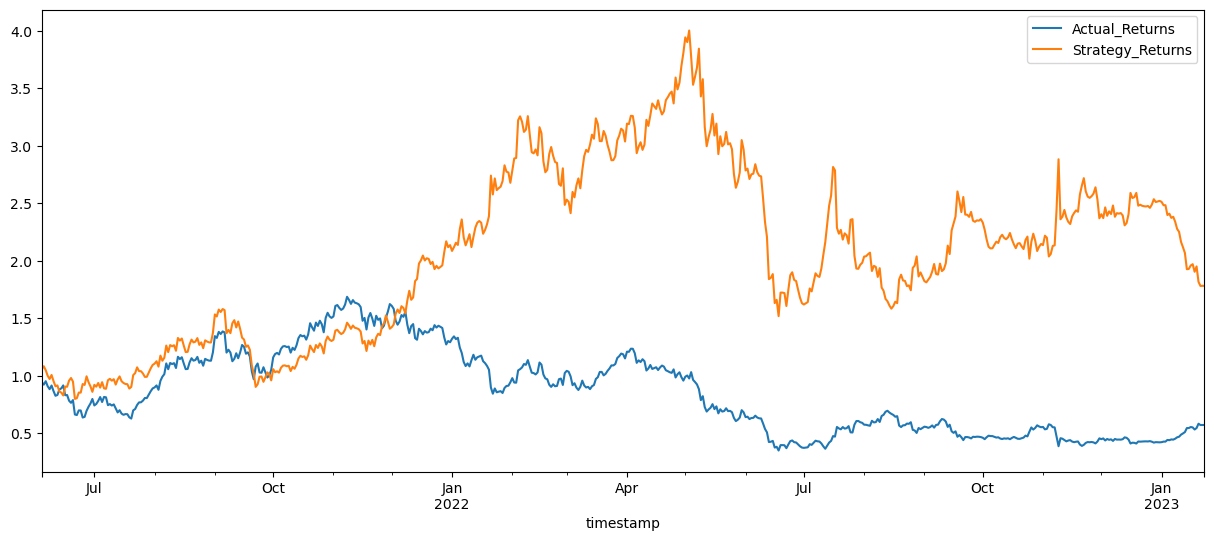

In [7]:
# Create a new empty predictions DataFrame:
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = attributes_df["change"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy_Returns'] = predictions_df["Actual_Returns"] * predictions_df["Predicted"]

# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot(figsize=(15,6))

In [8]:
# returns
strategy_return = predictions_df.Predicted * attributes_df.change

fg_return = (strategy_return + 1).cumprod()

fg_final = fg_return[-1]

print(f'Fear and Greed strategy returns (Testing data):  {round(fg_final, 2)}')

Fear and Greed strategy returns (Testing data):  1.78


**F&G and TA as features:**

In [14]:
TA_ = FGTA_df.copy()

# add technical indicators
TA_['RSI'] = pa.rsi(TA_.Close, length=16)
TA_['50_EMA'] = pa.ema(TA_.Close, length=50)
TA_['13_EMA'] = pa.ema(TA_.Close, length=13)
TA_['5_EMA'] = pa.ema(TA_.Close, length=5)
TA_ = TA_.dropna()

In [15]:
# FG and TA features
X2 = TA_[['FG', 'FG_signal_-1', 'FG_signal_1', 'RSI', '50_EMA']].shift().dropna()
X2 = X2.iloc[1:]

# target = perfect_signal (-1 = Short, 1 = Long)
y2 = TA_['perfect_signal'].shift(-1).dropna()
y2 = y2.iloc[1:]
y2.value_counts()

 1.0    905
-1.0    858
Name: perfect_signal, dtype: int64

In [16]:
# split training and testing
# start of the training period
training_begin = X2.index.min()
# ending period for the training data with an offset of 40 months
training_end = X2.index.min() + DateOffset(months=40)

# Generate the X_train and y_train DataFrames
X2_train = X2.loc[training_begin:training_end]
y2_train = y2.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X2_test = X2.loc[training_end:].dropna()
y2_test = y2.loc[training_end:].dropna()

# Scale features
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X2_scaler = scaler.fit(X2_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

In [17]:
# Create model
svm_model2 = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model2 = svm_model2.fit(X2_train_scaled, y2_train)

# Use the trained model to predict the trading signals for the training data
svm_pred2 = svm_model2.predict(X2_train_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report2 = classification_report(y2_train, svm_pred2)

# Print the classification report
print(svm_testing_report2)

              precision    recall  f1-score   support

        -1.0       0.53      0.44      0.48       583
         1.0       0.55      0.64      0.59       633

    accuracy                           0.54      1216
   macro avg       0.54      0.54      0.54      1216
weighted avg       0.54      0.54      0.54      1216



<AxesSubplot:xlabel='timestamp'>

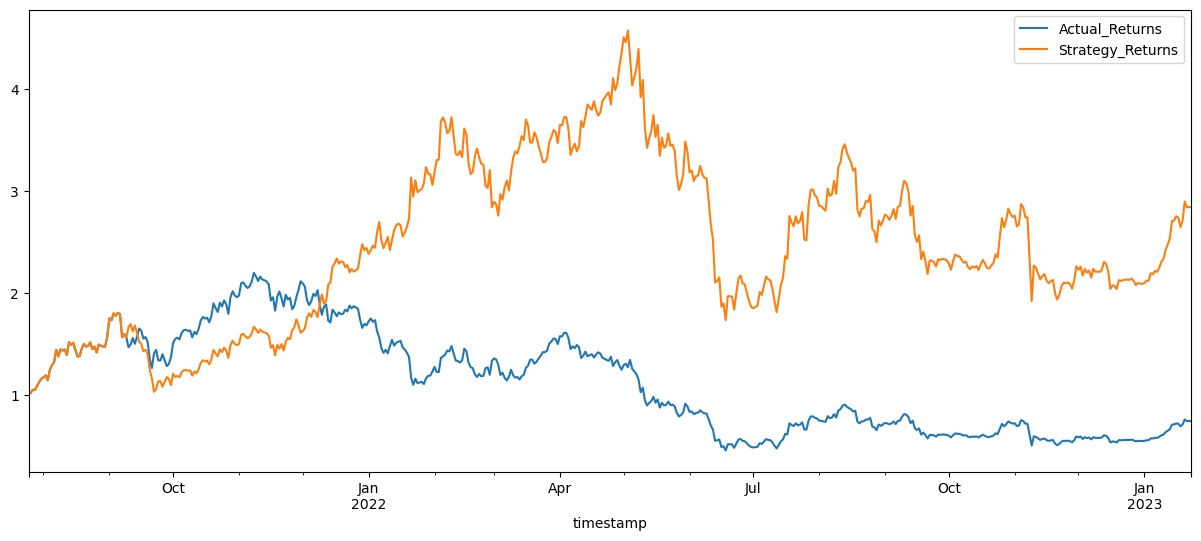

In [18]:
# Create a new empty predictions DataFrame:
testing_signal_predictions2 = svm_model2.predict(X2_test_scaled)

# Create a predictions DataFrame
predictions_df2 = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df2['Predicted'] = testing_signal_predictions2

# Add the actual returns to the DataFrame
predictions_df2['Actual_Returns'] = TA_["change"]

# Add the strategy returns to the DataFrame
predictions_df2['Strategy_Returns'] = predictions_df2["Actual_Returns"] * predictions_df2["Predicted"]

# Plot the actual returns versus the strategy returns
(1 + predictions_df2[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot(figsize=(15,6))

In [19]:
# returns
strategy_returns2 = predictions_df2.Predicted * TA_.change

fgta_return = (strategy_returns2 + 1).cumprod()

fgta_final = fgta_return[-1]

print(f'Fear and Greed AND TA strategy returns (Testing data):  {round(fgta_final, 2)}')

Fear and Greed AND TA strategy returns (Testing data):  2.84


**SVM Market Momentum (only TA):**

In [ ]:
from finta import TA

In [20]:
# read CSV to df
Mom_df = pd.read_csv('../data_collection/MOM_.csv')
Mom_df = Mom_df.set_index('Date')
Mom_df.index = pd.to_datetime(Mom_df.index)

TA_only = Mom_df.copy()
TA_only = TA_only.dropna()

# get dummies on 'MM signal' column

TA_only['MM Signal'] = pd.Categorical(TA_only['MM Signal'])
dummies = pd.get_dummies(TA_only['MM Signal'], prefix='MM_signal')
TA_only = TA_only.drop(['MM Signal'], axis=1)
TA_only = pd.concat([TA_only, dummies], axis=1)

# Initialize perfect signal column
TA_only['perfect_signal'] = 0.0

# When 'change' is greater than or equal to 0, generate buy signal
TA_only.loc[(TA_only['Actual Returns'] >= 0), 'perfect_signal'] = 1

# When 'change' is less than 0, generate short signal
TA_only.loc[(TA_only['Actual Returns'] < 0), 'perfect_signal'] = -1

# Calculate the strategy returns and add to DataFrame
TA_only['perfect_returns'] = TA_only['Actual Returns'] * TA_only['perfect_signal']

# shift 'perfect_signal' to the beginning of each day
TA_only['perfect_signal'] = TA_only['perfect_signal'].shift(-1).dropna()

In [21]:
# TA features
X1 = TA_only[['Volume', 'mm', 'MM_signal_-1.0', 'MM_signal_1.0']].dropna()
X1 = X1.iloc[1:]

# target = perfect_signal (-1 = Short, 1 = Long)
y1 = TA_only['perfect_signal'].dropna()
y1 = y1.iloc[1:]
y1.value_counts()

 1.0    921
-1.0    879
Name: perfect_signal, dtype: int64

In [22]:
# split training and testing
# start of the training period
training_begin = X1.index.min()
# ending period for the training data with an offset of 40 months
training_end = X1.index.min() + DateOffset(months=40)

# Generate the X_train and y_train DataFrames
X1_train = X1.loc[training_begin:training_end]
y1_train = y1.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X1_test = X1.loc[training_end:].dropna()
y1_test = y1.loc[training_end:].dropna()

# Scale features
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X1_scaler = scaler.fit(X1_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [23]:
# Create model
svm_model1 = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model1 = svm_model1.fit(X1_train_scaled, y1_train)

# Use the trained model to predict the trading signals for the training data
svm_pred1 = svm_model1.predict(X1_train_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report1 = classification_report(y1_train, svm_pred1)

# Print the classification report
print(svm_testing_report1)

              precision    recall  f1-score   support

        -1.0       0.54      0.52      0.53       589
         1.0       0.56      0.58      0.57       628

    accuracy                           0.55      1217
   macro avg       0.55      0.55      0.55      1217
weighted avg       0.55      0.55      0.55      1217



<AxesSubplot:xlabel='Date'>

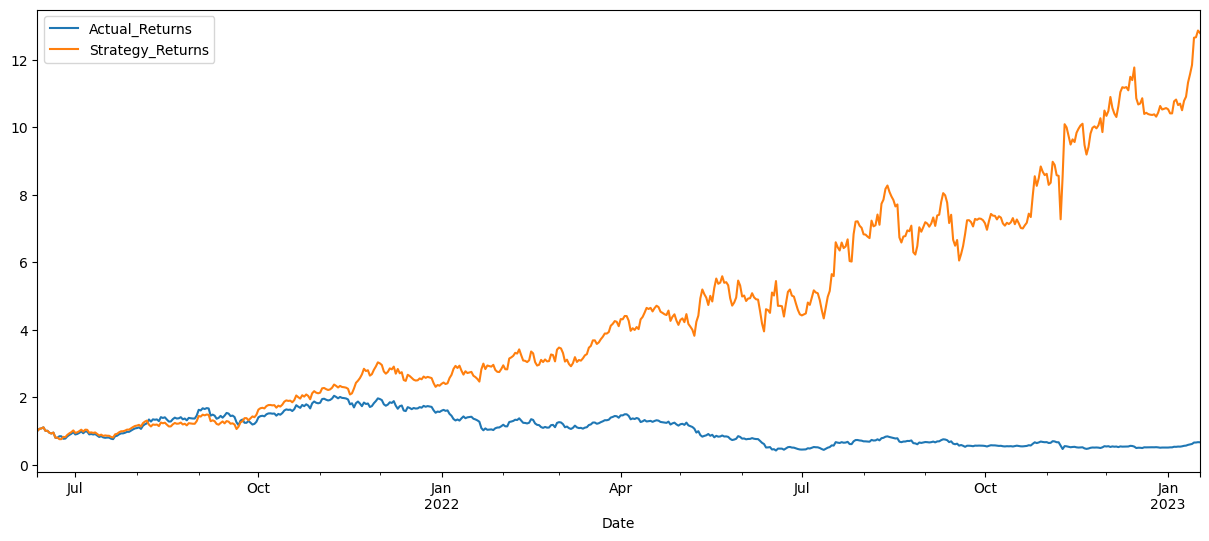

In [24]:
# Create a new empty predictions DataFrame:
testing_signal_predictions1 = svm_model1.predict(X1_test_scaled)

# Create a predictions DataFrame
predictions_df1 = pd.DataFrame(index=X1_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df1['Predicted'] = testing_signal_predictions1

# Add the actual returns to the DataFrame
predictions_df1['Actual_Returns'] = TA_only["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df1['Strategy_Returns'] = predictions_df1["Actual_Returns"] * predictions_df1["Predicted"]

# Plot the actual returns versus the strategy returns
(1 + predictions_df1[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot(figsize=(15,6))

In [25]:
# returns
strategy_returns1 = predictions_df1.Predicted * TA_only['Actual Returns']

ta_return = (strategy_returns1 + 1).cumprod()

ta_final = ta_return[-1]

print(f'Market Momentum TA strategy returns (Testing data):  {round(ta_final, 2)}')

Market Momentum TA strategy returns (Testing data):  12.8


**Results on testing data (ROI):**

In [26]:
print(f"F&G strategy Features (Sentiment only): {round(fg_final, 2)}")
print("----------------------------")
print(f"F&G strategy AND TA Features: {round(fgta_final, 2)}")
print("----------------------------")
print(f"Market Momentum strategy Features (TA only): {round(ta_final, 2)}")
print("----------------------------")

F&G strategy Features (Sentiment only): 1.78
----------------------------
F&G strategy AND TA Features: 2.84
----------------------------
Market Momentum strategy Features (TA only): 12.8
----------------------------
